In [4]:
import pandas as pd
import numpy as np
from tools.preprocessing_data import encode_data_to_numeric, get_data_since_date, load_data
from tools.add_finance_data import add_finance_data
from sklearn.decomposition import PCA
from factor_analyzer.rotator import Rotator
from sklearn.preprocessing import MinMaxScaler

/Users/inagege/Documents/00_Uni/SeminarSocialSentimentInTimesOfCrisis/tools/preprocessing_data.py:18: DtypeWarning: Columns (55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,73,74,75,148,161,166) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv("../Data/data_sample_700_SOSEC_dataset_germany.csv")
[*********************100%***********************]  1 of 1 completed


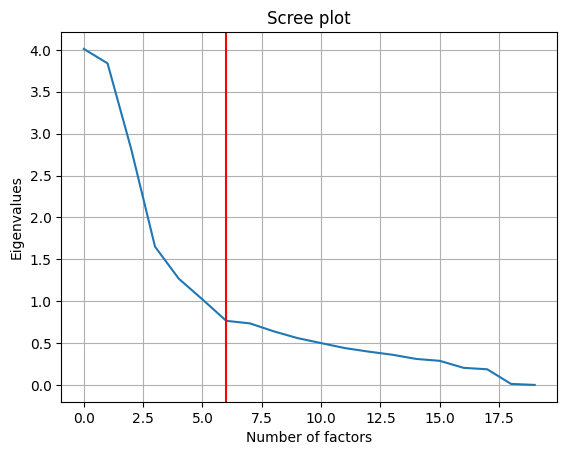

Eigenvalues: [ 4.01144135e+00  3.83917103e+00  2.81228417e+00  1.65059229e+00
  1.26860169e+00  1.02064270e+00  7.65368963e-01  7.34588174e-01
  6.40119705e-01  5.59286155e-01  4.99184439e-01  4.39812081e-01
  3.97577898e-01  3.60427008e-01  3.10509885e-01  2.87507100e-01
  2.04106761e-01  1.86562096e-01  1.22165078e-02 -5.23290303e-16]
Eigenvalues > 1 (Kaiser criterion): [4.01144135 3.83917103 2.81228417 1.65059229 1.26860169 1.0206427 ]
Number of factors according to Kaiser criterion: 6


In [5]:
data = load_data()
data = add_finance_data(data)
data = get_data_since_date(data, '2024-05-05')
data = encode_data_to_numeric(data)

#relevant_columns = ['consumer_price_index', 'inflation_rate', 'dax_points', 'interest_rate', 'F3A21_1', 'F71invest', 'F5A10_2', 'F5aA1_1', 'F5aA2_1', 'F5aA3_1', 'F5aA4_1', 'F5aA5_1', 'F5bA1_1','F5bA2_1' ,'F5bA3_1' ,'F5bA4_1' ,'F5bA5_1']
relevant_columns = ['consumer_price_index', 'inflation_rate', 'interest_rate', 'F3A21_1', 'F5A10_2', 'F5aA1_1', 'F5aA2_1', 'F5aA3_1', 'F5aA4_1', 'F5aA5_1', 'F5bA1_1','F5bA2_1' ,'F5bA3_1' ,'F5bA4_1' ,'F5bA5_1', 'F5A10_1', 'F5A11_1', 'F5A12_1', 'F5A13_1', 'F5A14_1', 'F71invest']

data = data[relevant_columns]

scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

correlation_matrix = data.corr()
correlation_matrix.fillna(0, inplace=True)

# Calculate eigenvalues of the correlation matrix
eigenvalues, _ = np.linalg.eig(correlation_matrix)

#sort eigenvalues
eigenvalues = np.sort(eigenvalues)[::-1]

#plot eigenvalues
import matplotlib.pyplot as plt
plt.plot(eigenvalues)
plt.title('Scree plot')
plt.xlabel('Number of factors')
plt.ylabel('Eigenvalues')
plt.grid()

#plt.axhline(y=2.5, color='g', linestyle='-')

#insert a vertical line at x=15
plt.axvline(x=6, color='r', linestyle='-')

plt.show()

# Apply Kaiser criterion: keep factors with eigenvalues > 1
kaiser_factors = eigenvalues[eigenvalues > 1]
print("Eigenvalues:", eigenvalues)
print("Eigenvalues > 1 (Kaiser criterion):", kaiser_factors)
print("Number of factors according to Kaiser criterion:", len(kaiser_factors))

#fill nans in each column which includes only 1s and 0s with mod and other columns with mean
for column in data.columns:
    if set(data[column].dropna(inplace=False).unique()) <= {0, 1}:
        data[column] = data[column].fillna(data[column].mode()[0])
    else:
        data[column] = data[column].fillna(data[column].mean())

In [6]:
#fill data nans before applying PCA
pca = PCA(n_components=6)
#pca = PCA(n_components=20)
pca.fit(data)

# Get the component matrix
component_matrix = pca.components_.T

# Add a small epsilon value to avoid numerical instability
epsilon = 1e-100
component_matrix += epsilon

rotator = Rotator()
rotated_matrix = rotator.fit_transform(component_matrix)

# Create a DataFrame for the rotated component matrix
rotated_matrix_df = pd.DataFrame(rotated_matrix, 
                                 index=data.columns, 
                                 columns=[f'Component {i+1}' for i in range(6)])

print(rotated_matrix_df)

                      Component 1  Component 2  Component 3  Component 4  \
consumer_price_index    -0.010807    -0.005114     0.606577    -0.006845   
inflation_rate          -0.010807    -0.005114     0.606577    -0.006845   
interest_rate            0.024690    -0.009977    -0.510338    -0.011224   
F3A21_1                  0.054617    -0.111608     0.006155    -0.206843   
F5A10_2                  0.077490    -0.089484     0.010566    -0.290408   
F5aA1_1                 -0.110639     0.421627    -0.002232    -0.100793   
F5aA2_1                  0.128180     0.674291     0.003704     0.103838   
F5aA3_1                  0.442000    -0.018829     0.032305     0.013658   
F5aA4_1                  0.083507    -0.000431    -0.009613    -0.002101   
F5aA5_1                  0.070864    -0.005789    -0.008359     0.000745   
F5bA1_1                  0.113083     0.011413     0.001523    -0.045183   
F5bA2_1                  0.581086    -0.050117     0.006333    -0.042535   
F5bA3_1     

In [7]:
# Assign each feature to the component with the highest value
assigned_components = rotated_matrix_df.idxmax(axis=1)

# Create a new DataFrame to show the assignment
assigned_components_df = pd.DataFrame({'Assigned Component': assigned_components})
assigned_components_df = assigned_components_df.reset_index()
assigned_components_df.columns = ['Feature', 'Assigned Component']
print(assigned_components_df)

                 Feature Assigned Component
0   consumer_price_index        Component 3
1         inflation_rate        Component 3
2          interest_rate        Component 1
3                F3A21_1        Component 5
4                F5A10_2        Component 1
5                F5aA1_1        Component 2
6                F5aA2_1        Component 2
7                F5aA3_1        Component 1
8                F5aA4_1        Component 1
9                F5aA5_1        Component 1
10               F5bA1_1        Component 5
11               F5bA2_1        Component 1
12               F5bA3_1        Component 1
13               F5bA4_1        Component 2
14               F5bA5_1        Component 6
15               F5A10_1        Component 2
16               F5A11_1        Component 6
17               F5A12_1        Component 2
18               F5A13_1        Component 5
19               F5A14_1        Component 1


In [8]:
# Create a new DataFrame with components as columns and features as rows
components = assigned_components_df['Assigned Component'].unique()
features = assigned_components_df.index
boolean_df = pd.DataFrame(False, index=features, columns=components)

# Populate the DataFrame with True where the feature is assigned to the component
for feature, component in assigned_components_df['Assigned Component'].items():
    boolean_df.loc[feature, component] = True

print(boolean_df)

    Component 3  Component 1  Component 5  Component 2  Component 6
0          True        False        False        False        False
1          True        False        False        False        False
2         False         True        False        False        False
3         False        False         True        False        False
4         False         True        False        False        False
5         False        False        False         True        False
6         False        False        False         True        False
7         False         True        False        False        False
8         False         True        False        False        False
9         False         True        False        False        False
10        False        False         True        False        False
11        False         True        False        False        False
12        False         True        False        False        False
13        False        False        False       

In [9]:
# Load the CSV file into a DataFrame
feature_meanings_df = pd.read_csv('../Data/SOSEC_Codebook_Germany_2024_May.csv', delimiter=';')

# Drop duplicate rows based on the 'Feature' column, keeping only the last occurrence
feature_meanings_df = feature_meanings_df.drop_duplicates(subset='Feature', keep='last')

# Merge the DataFrame
merged_df = assigned_components_df.merge(feature_meanings_df, on='Feature', how='left')
merged_df.drop(columns=['Unnamed: 2'], inplace=True)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('../results/ECA/assigned_features_screen_test_6_20240505_noDax_noAcademic.csv', index=False)
print(merged_df.head(10))

                Feature Assigned Component  \
0  consumer_price_index        Component 3   
1        inflation_rate        Component 3   
2         interest_rate        Component 1   
3               F3A21_1        Component 5   
4               F5A10_2        Component 1   
5               F5aA1_1        Component 2   
6               F5aA2_1        Component 2   
7               F5aA3_1        Component 1   
8               F5aA4_1        Component 1   
9               F5aA5_1        Component 1   

                                            question  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3   Aktuell ergibt es Sinn in Aktien zu investieren.  
4                                   Die Aktienmärkte  
5  ...von öffentlichen Medienanstalten  (ARD, ZDF...  
6  ...von privaten etablierten Medienanstalten  (...  
7  ...von alternativen Anbietern (newsblogger, so... 